In [1]:
%run ../config/init.py

## Creating reference bed file from GTF

In [2]:
os.chdir(GENOME)
if not os.path.exists(GENOME_BED):
    !{CWLRUNNER} {CWLWORKFLOWS}/UCSC/gtftobed.cwl --gtf {GENOME_GTF}   
    
    

### Loading samples from the alignments folder

In [3]:
data_dir = os.path.join(RESULTS, DATASET, 'alignments')
os.chdir(data_dir)
files = [ f for ds,dr,fs in os.walk('./') for f in fs if f.endswith('.bam')]

### Creating folder named: quantification

In [4]:
result_dir = os.path.join(RESULTS, DATASET, 'quantification')
if not os.path.exists(result_dir):
    os.mkdir(result_dir)
os.chdir(result_dir)
os.environ['w'] = result_dir

### Executing quantification workflow

In [8]:
%%time
count = 0
str_cmd = ''
cmd_header = '{0} {1}/RNA-Seq/rnaseq-tpmcalculator-SE.cwl --gtf {2} -q 255 -r {3} --genome_name {4} --sorted_bam '.format(
        CWLRUNNER, CWLWORKFLOWS, GENOME_GTF, GENOME_BED, GENOME_NAME)
for f in files:
    count += 1
    str_cmd += '{0} {1}\n'.format(cmd_header, os.path.join(data_dir,f))
with open('commands', "w") as fin:
    fin.write(str_cmd) 
errors = !cat commands | parallel -j 16  
for e in errors:
    if 'Final process status is success' == e:
        count -= 1
if count == 0:
    print('Run completed')
else:
    print('There are errors. Please check.')        



There are errors. Please check.
CPU times: user 53.3 ms, sys: 46.1 ms, total: 99.4 ms
Wall time: 55.2 s


### Creates TPM and reads matrices for genes

In [6]:
data = {}
columns = ['ExonTPM', 'ExonReads']
output_suffix = "_sorted_genes.out"
files = [ f for ds, df, files in os.walk('./') for f in files if output_suffix in f]
for column in columns:
    print(column)
    data[column] = pandas.DataFrame()
    for f in files:
        # Get sample name removing the suffix and check if the output is compressed
        if f.endswith('.gz'):
            output_suffix_real = output_suffix + '.gz'
        else:
            output_suffix_real = output_suffix
        s = f.replace(output_suffix_real, '')
        df = pandas.read_csv(f, sep='\t')
        df = df[['Gene_Id', 'Chr', 'Start', 'End', 'ExonLength', column]]
        df = df.rename(index=str, columns={column: s})
        if data[column].empty:
            data[column] = df
        else:
            data[column] = data[column].merge(df, on=['Gene_Id', 'Chr', 'Start', 'End', 'ExonLength'], how='outer')
    print('Data columns: ' + str(len(data[column].columns)))
    print('Data rows: ' + str(len(data[column])))
    
    # Printing TSV matrices    
    data[column]['Gene_Chr_Start'] = data[column]['Gene_Id'] + '_' + data[column]["Chr"] + '_' + data[column]["Start"].map(str)
    data[column] = data[column].drop(['Gene_Id'], axis=1)
    cols = data[column].columns.tolist()
    cols = cols[-1:] + cols[:-1]
    data[column] = data[column][cols]
    data[column].to_csv( column + '.tsv', sep='\t', index=False, na_rep='0')

ExonTPM
Data columns: 39
Data rows: 24295
ExonReads
Data columns: 39
Data rows: 24295


## Plotting Exon TPM and read count per sample

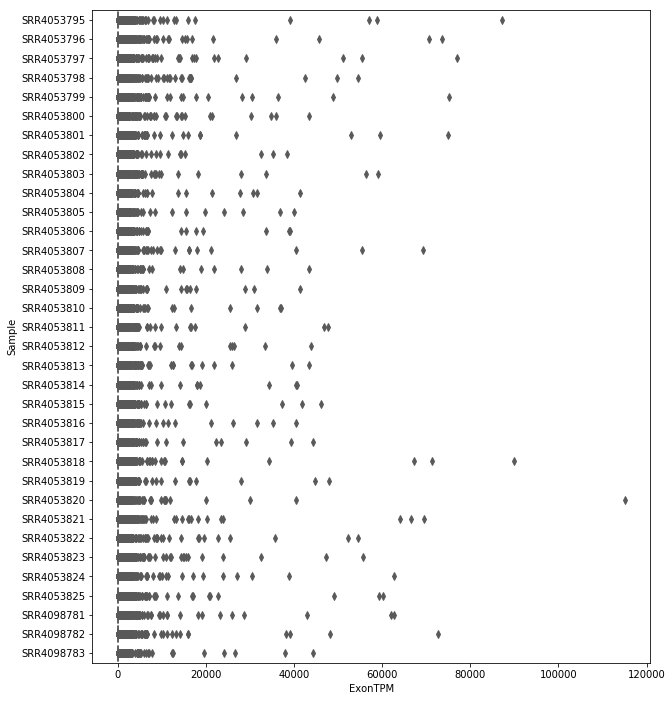

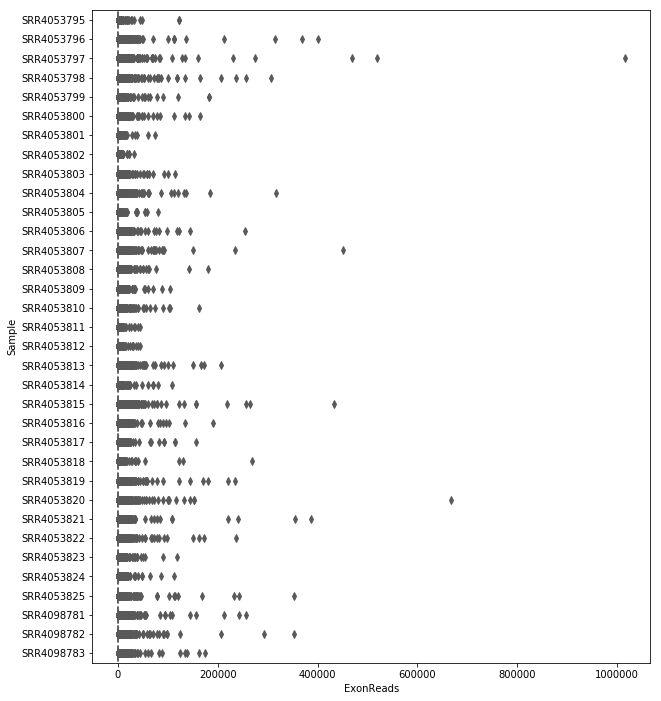

In [7]:
columns = ['ExonTPM', 'ExonReads']
output_suffix = "_sorted_genes.out"
files = [ f for ds, df, files in os.walk('./') for f in files if output_suffix in f]
files.sort()
for column in columns:    
    plt.figure(figsize=(10, 12)) 
    toPlot = []
    for f in files:
        if f.endswith('.gz'):
            output_suffix_real = output_suffix + '.gz'
        else:
            output_suffix_real = output_suffix
        s = f.replace(output_suffix_real, '')
        if s in data[column]:
            for r in data[column][s]:
                toPlot.append([r, s])
    d = pandas.DataFrame(toPlot, columns=[column, 'Sample'])
    ax = sns.boxplot(y='Sample', x=column, data=d, orient="h", palette="Set2")
